In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import physics as phys
import utilities as utils
import spectrum as spec
import transferfunction as tf
import matplotlib
import matplotlib.pyplot as plt
import time as time

matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits

In [3]:
log_rs = np.log(4) + (np.arange(50)+1)*(np.log(31) - np.log(4))/50
log_rs = np.flipud(log_rs)

mmin = 5e3
mmax = 1e13
nwimpsteps = 40
mwimp = mmin*np.exp((np.arange(nwimpsteps))*np.log(mmax/mmin)/nwimpsteps)
mwimpmax = mwimp[-1]

nengsteps = 500
lowinjE = 3e3 + 100.
eng = lowinjE*np.exp((np.arange(nengsteps)*np.log(mwimpmax/lowinjE)/nengsteps))

In [4]:
tf_raw = np.load('/Users/hongwan/Dropbox (MIT)/transferfunction.npy')
tf_raw = np.swapaxes(tf_raw,0,1)
tf_raw = np.swapaxes(tf_raw,1,2)
tf_raw = np.swapaxes(tf_raw,2,3)
tf_raw = np.flip(tf_raw,axis=0)
# Claim: tf ordering is now (1+z, xe, outE, injE), redshift in decreasing order.
print(tf_raw.shape)

#tf_raw_list is an array of dimensions [N_injE, N_rs, N_outE].  
tf_raw_list =[[spec.Spectrum(eng, tf_raw[i,0,:,j], np.exp(log_rs[i])) for i in np.arange(tf_raw.shape[0])] 
            for j in np.arange(tf_raw.shape[-1])]
#transfer_func_table is a list of length N_injE, each with a Transferfunction object, with rs and outE as abscissa.
transfer_func_table = [tf.Transferfunction(spec_list) for spec_list in tf_raw_list]

(50, 1, 500, 500)


In [5]:
#Normalize each transfer_func in transfer_func_table by dN/dE of a single particle of injE. 
#Two particles injected initially. 
dNdE_norm = spec.rebin_N_arr(np.ones(eng.size), eng, eng)

for i in np.arange(eng.size):
    transfer_func_table[i] /= (2*dNdE_norm.dNdE[i])

In [38]:
#Initialize
start_mwimp = eng[299]
rs_list = np.exp(np.arange(log_rs[0], log_rs[2], -0.002))

photon_spec_init = spec.rebin_N_arr(np.array([2]), np.array([eng[299]]), eng)
photon_spec_init.rs = rs_list[0]

In [39]:
print(rs_list)

[ 31.          30.93806196  30.87624767  30.81455689  30.75298936
  30.69154485  30.6302231   30.56902387  30.50794692  30.446992
  30.38615887  30.32544729  30.264857    30.20438778  30.14403937
  30.08381154  30.02370404  29.96371664  29.9038491   29.84410117
  29.78447261  29.7249632   29.66557268  29.60630083  29.5471474
  29.48811216  29.42919487  29.3703953   29.31171321  29.25314837
  29.19470054  29.13636949  29.07815499  29.02005679  28.96207468
  28.90420842  28.84645777  28.78882251  28.7313024   28.67389722
  28.61660674]


In [40]:
photon_spectra = spec.Spectra([photon_spec_init])

for rs in rs_list:
    tf_at_rs = tf.Transferfunction([transfer_func.at_rs(rs) for transfer_func in transfer_func_table]) 
    photon_spectra.append(tf_at_rs.sum_specs_by_weight(photon_spectra[-1]))
    photon_spectra[-1].rs = rs  

In [9]:
file = fits.open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits")

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [10]:
file_spectra = spec.Spectra([spec.Spectrum(file_eng, photspec, rs) 
                             for photspec,rs in zip(file_photonspectrum, file_rs)])

In [11]:
file_spectra.rebin(eng)

In [12]:
file_spectra.rs

array([ 31.        ,  30.96901549,  30.93806196, ...,   4.00677711,
         4.00277233,   3.99877156])

28.6738972228
28.6738972228


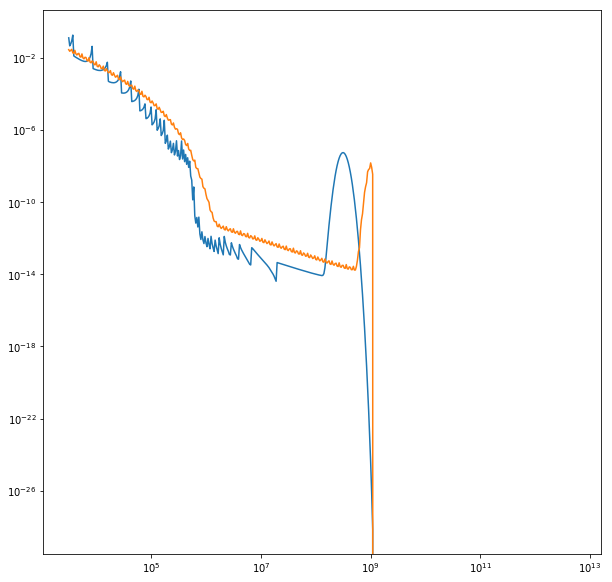

In [42]:
i=40
j=(i-1)*2
print(photon_spectra[i].rs)
print(file_spectra[j].rs)

ax = plt.subplot(1,1,1)
plt.plot(photon_spectra.eng, photon_spectra[i].dNdE)
plt.plot(file_spectra.eng, file_spectra[j].dNdE)
ax.set_xscale('log')
ax.set_yscale('log')
# b = file_spectra.plot(2)
# axb = b.add_subplot(1,1,1)
# axb.set_xscale('log')
# axb.set_yscale('log')